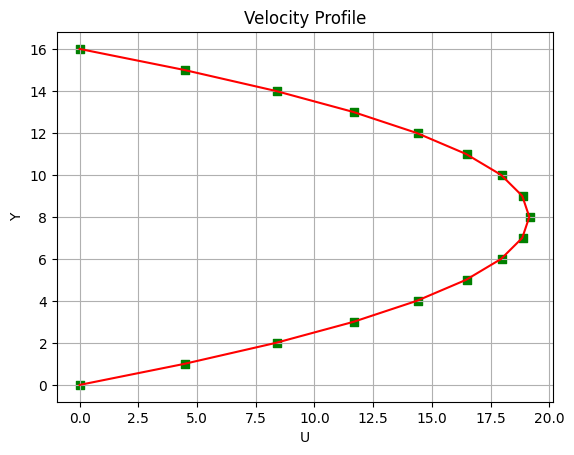

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

nx = 21   # Grid points in x
ny = 17   # Grid points in y
N = 9     # for D2Q9 model
tau = 1   # Relaxation Parameter
nt = 2000 # Number of time steps

omega = 1/tau   # Collision Frequency
visc = (tau - 0.5)/3    # Kinematic viscosity
dpdx = 1e-1     # Pressure gradient
H = ny - 1      # Height of channel

# Define arrays
cx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
cy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
ux = np.zeros((nx, ny))
uy = np.zeros((nx, ny))
uu = np.zeros((nx, ny))
rho = np.ones((nx, ny))
cu = np.zeros((nx, ny, N))
cu_sq = np.zeros((nx, ny, N))
source = np.zeros((nx,ny, N))
u_exact = np.ones((ny))

f = np.ones((nx, ny, N))
feq = np.ones((nx, ny, N))
ft = np.ones((nx,ny,N))


# Initialization
for i in range(nx):
    for j in range(1,ny-1):
        for k in range(N):
            f[i,j,k] = rho[i,j] * w[k]


# Time loop starts
for t in range(nt):
    # Compute density and velocity
    for i in range(nx):
        for j in range(1, ny-1):
            rho[i, j] = 0
            ux[i, j] = 0
            uy[i, j] = 0
            for k in range(N):
                rho[i, j] = rho[i, j] + f[i, j, k]
                ux[i, j] = ux[i, j] + f[i, j, k] * cx[k]
                uy[i, j] = uy[i, j] + f[i, j, k] * cy[k]
            ux[i, j] = ux[i, j] + ((dpdx) * 0.5) / rho[i, j]
            uy[i, j] = uy[i, j] / rho[i, j]
            uu[i, j] = ux[i, j] * ux[i, j] + uy[i, j] * uy[i, j]

            for k in range(N):
                cu[i, j, k] = ux[i, j] * cx[k] + uy[i, j] * cy[k]
                cu_sq[i, j, k] = cu[i, j, k] * cu[i, j, k]
                source[i, j, k] = (1 - (0.5 / tau)) * (dpdx) * w[k] * (3 * (cx[k] - ux[i, j]) + 9 * (cx[k] * ux[i, j] + cy[k] * uy[i, j]) * cx[k])
                feq[i, j, k] = w[k] * rho[i, j] * (1 + 3 * cu[i, j, k] + 4.5 * cu_sq[i, j, k] - 1.5 * uu[i, j])
                # Collision
                ft[i, j, k] = -((f[i, j, k] - feq[i, j, k]) / tau) + f[i, j, k] + source[i, j, k]

    # Streaming
    for i in range(nx):
        for j in range(1, ny-1):
            for k in range(N):
                ia = i + cx[k]
                ja = j + cy[k]
                # Periodicity in lattice
                if ia < 0:
                    ia = nx - 1
                if ia > nx - 1:
                    ia = 0
                f[ia,ja,k] = ft[i,j,k]

    # Boundary conditions
    for j in range(1,ny-1):   # Bounce-back at bottom wall
        ft[0, j, 1] = ft[nx-1, j, 1]
        ft[0, j, 5] = ft[nx - 1, j, 5]
        ft[0, j, 8] = ft[nx - 1, j, 8]
        ft[nx-1, j, 3] = ft[0, j, 3]
        ft[nx-1, j, 6] = ft[0, j, 6]
        ft[nx-1, j, 7] = ft[0, j, 8]

    for i in range(nx):      # Bounce-back at top wall
        ft[i, 1, 2] = ft[i, 1, 4]
        ft[i, 1, 5] = ft[i, 1, 7]
        ft[i, 1, 6] = ft[i, 1, 8]
        ft[i, ny-2, 4] = ft[i, ny-2, 2]
        ft[i, ny-2, 7] = ft[i, ny-2, 5]
        ft[i, ny-2, 8] = ft[i, ny-2, 6]

# Analytical Solution
y = np.linspace(0, ny-1, ny)
yo = np.linspace(0, ny-1, ny)
y1 = np.zeros((ny))
for j in range(ny):
  y1[j] = (j) / H
  u_exact[j] = 0.5 * dpdx * H * H * (y1[j] - y1[j] * y1[j]) / visc
  if (j==0 | j==ny-1):
     u_exact[j] = 0

# Plot visualization
plt.plot(ux[i,:], y, color='red')
plt.grid(True)
plt.scatter(u_exact, yo, color='green', marker='s')
plt.grid(True)
plt.title('Velocity Profile')
plt.xlabel('U')
plt.ylabel('Y')
plt.show()
